# RetinaNet Inference - Visual Walkthrough

In [1]:
import os
import sys

import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from retinanet import retinanet_resnet50_fpn

from utils import COCO_LABELS

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)
COLORS = np.random.uniform(size=(len(COCO_LABELS), 3))

## Load a pretrained RetinaNet model 

In [11]:
# load pretrained model
retinanet = retinanet_resnet50_fpn(
    pretrained=True, pretrained_backbone=True, nms_off=False
)

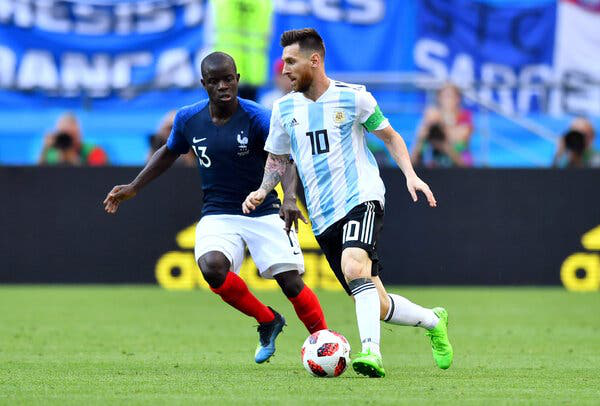

In [12]:
# load an image
test_img = Image.open("data/soccer_img.jpg")
test_img

In [13]:
# define transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [14]:
def predict(model, image, transform, detection_threshold):
    """
    Use a trained Pytorch detection model to make inference on an input image

    Args:
        model - Pytorch detetection model
        image - PIL image as RGB format
        transform - torchvision Compose object
        detection_threshold -

    Returns:


    """

    if model.training:
        model.eval()

    image = transform(image).unsqueeze(0)
    outputs = model(image)[0]

    idxs = np.where(outputs["scores"] > detection_threshold)

    boxes = outputs["boxes"][idxs]
    scores = outputs["scores"][idxs]
    labels = outputs["labels"][idxs]
    outputs = {"boxes": boxes, "scores": scores, "labels": labels}

    return outputs

In [15]:
%time

a = predict(
    model=retinanet, image=test_img, transform=transform, detection_threshold=0.9
)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


### View predictions from an image

In [16]:
def convert_bb_spec(xmin, ymin, xmax, ymax):

    x = xmin
    y = ymin
    width = xmax - xmin
    height = ymax - ymin

    return x, y, width, height


def plot_predictions(image, outputs, label_map, nms_off=False):
    """
    Overlay bounding box predictions on an image

    Args:
        image - PIL image as RGB format
        outputs - boxes, scores, labels output from predict()
        label_map - list mapping of idx to label name
        nms_off - indicates if visualization is with or without NMS

    """

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    np.random.seed(24)
    colors = np.random.uniform(size=(len(label_map), 3))
    boxes, scores, labels = outputs.values()

    for i, box in enumerate(boxes):

        x, y, width, height = convert_bb_spec(*box)
        top = y + height

        patch = patches.Rectangle(
            (x, y),
            width,
            height,
            edgecolor=colors[labels[i]],
            linewidth=1,
            facecolor="none",
        )
        ax.add_patch(patch)

        if nms_off:
            continue

        ax.text(
            x,
            y,
            label_map[labels[i]],
            color=colors[labels[i]],
            fontweight="semibold",
            horizontalalignment="left",
            verticalalignment="bottom",
        )
        ax.text(
            x + width,
            y + height,
            round(scores[i].item(), 2),
            color=colors[labels[i]],
            fontweight="bold",
            horizontalalignment="right",
            verticalalignment="top",
        )

    plt.axis("off")
    plt.show()

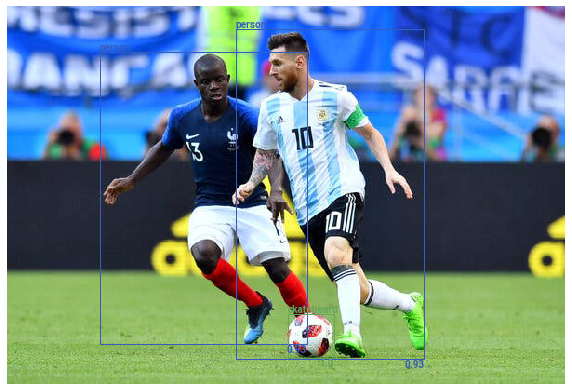

In [17]:
plot_predictions(test_img, a, COCO_LABELS, False)

## Anchor Generator

In [10]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [11]:
anchor_sizes = tuple(
    (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3)))
    for x in [32, 64, 128, 256, 512]
)
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

In [12]:
anchor_sizes

((32, 40, 50),
 (64, 80, 101),
 (128, 161, 203),
 (256, 322, 406),
 (512, 645, 812))

In [13]:
aspect_ratios

((0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0))

In [14]:
anchor_generator.num_anchors_per_location()

[9, 9, 9, 9, 9]

In [39]:
retinanet.viz_artifacts["anchors"]

[tensor([[ -23.,  -11.,   23.,   11.],
         [ -28.,  -14.,   28.,   14.],
         [ -35.,  -18.,   35.,   18.],
         ...,
         [ 881.,  322., 1243., 1046.],
         [ 834.,  228., 1290., 1140.],
         [ 775.,  110., 1349., 1258.]])]

In [41]:
retinanet.viz_artifacts["anchors"][0].shape

torch.Size([177678, 4])

In [33]:
def plot_anchors(image, boxes, sample):
    """
    Overlay anchor boxes on the original image

    Args:
        image - PIL image as RGB format
        boxes - Tensor(N,4) of all anchor box specs
        sample - percentage of anchorboxes to randomly select for visualization

    """

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    num_samples = int(sample * boxes.shape[0])
    sample_idxs = torch.randint(low=0, high=boxes.shape[0], size=(num_samples,))
    boxes = boxes[sample_idxs]

    for i, box in enumerate(boxes):

        x, y, width, height = convert_bb_spec(*box)
        top = y + height

        patch = patches.Rectangle(
            (x, y),
            width,
            height,
            edgecolor="red",
            linewidth=1,
            facecolor="none",
        )
        ax.add_patch(patch)

    plt.axis("off")
    plt.show()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 16 µs


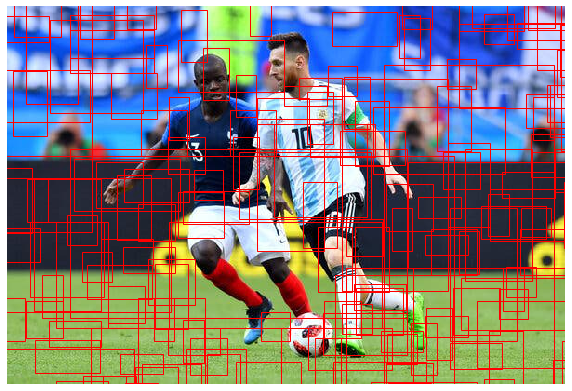

In [37]:
%time
plot_anchors(test_img, retinanet.viz_artifacts["anchors"][0], 0.003)

## Detections before NMS

In [18]:
# load pretrained model
retinanet_nms_off = retinanet_resnet50_fpn(
    pretrained=True, pretrained_backbone=True, nms_off=True
)

In [19]:
%time

b = predict(
    model=retinanet_nms_off,
    image=test_img,
    transform=transform,
    detection_threshold=0.9,
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


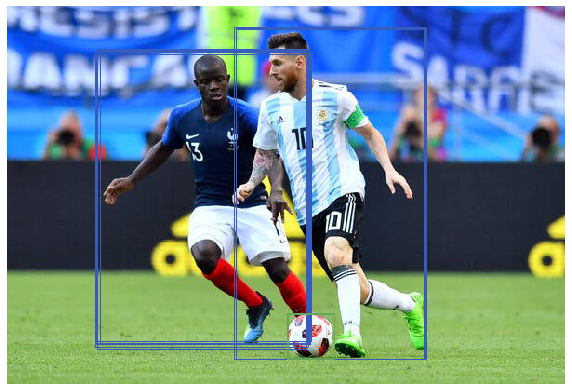

In [21]:
plot_predictions(test_img, b, COCO_LABELS, True)

### Visualize Feature Maps

In [26]:
len(retinanet.viz_artifacts["features"])

5

In [31]:
for i in range(len(retinanet.viz_artifacts["features"])):
    print(retinanet.viz_artifacts["features"][i].shape)

torch.Size([1, 256, 100, 148])
torch.Size([1, 256, 50, 74])
torch.Size([1, 256, 25, 37])
torch.Size([1, 256, 13, 19])
torch.Size([1, 256, 7, 10])


In [45]:
retinanet.viz_artifacts["features"][0][:, 1, :, :].shape

torch.Size([1, 100, 148])

In [52]:
retinanet.viz_artifacts["features"][0][:, 1, :, :].squeeze(0).shape

torch.Size([100, 148])

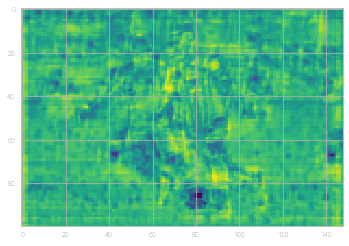

In [53]:
plt.imshow(
    retinanet.viz_artifacts["features"][0][:, 1, :, :].squeeze(0).detach().numpy()
)

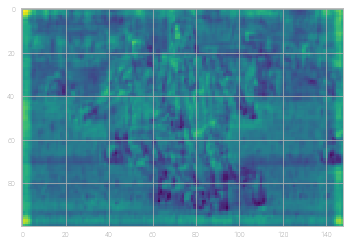

In [54]:
plt.imshow(
    retinanet.viz_artifacts["features"][0][:, 50, :, :].squeeze(0).detach().numpy()
)

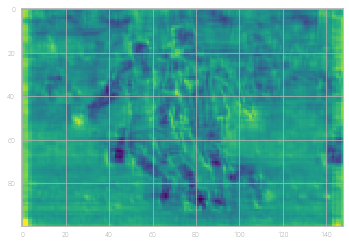

In [55]:
plt.imshow(
    retinanet.viz_artifacts["features"][0][:, 200, :, :].squeeze(0).detach().numpy()
)

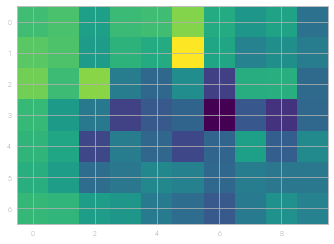

In [56]:
plt.imshow(
    retinanet.viz_artifacts["features"][4][:, 200, :, :].squeeze(0).detach().numpy()
)

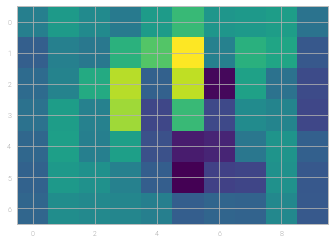

In [57]:
plt.imshow(
    retinanet.viz_artifacts["features"][4][:, 10, :, :].squeeze(0).detach().numpy()
)

In [ ]:

def plot_feature_map(feature_map, max_grid):
    
    fig, ax = plt.subplots(max_grid, max_grid, figsize=(7,7))
    channel_idx = 0
    
    for i in range(max_grid):
        for j in range(max_grid):
            ax[i][j].imshow(feature_map[0,:,:,channel_idx])
            ax[i][j].axis('off')
            
            channel_idx += 1
            
    fig.suptitle(f'Feature Map - Displaying {max_grid**2} of {feature_map.shape[3]} Channels')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [39]:
retinanet.backbone.out_channels

256

In [62]:
retinanet.viz_artifacts["head_outputs"]

{'cls_logits': tensor([[[-6.1763, -5.1967, -6.1140,  ..., -5.9401, -6.0899, -5.7210],
          [-6.1871, -5.5081, -6.3783,  ..., -6.2594, -6.2472, -5.9466],
          [-6.1293, -5.3812, -6.6695,  ..., -6.3391, -6.2340, -6.0159],
          ...,
          [-4.8555, -4.0939, -4.4975,  ..., -5.2162, -5.0455, -5.2566],
          [-4.8274, -4.5323, -4.6766,  ..., -5.6186, -5.1493, -5.5171],
          [-4.7624, -4.4403, -4.7001,  ..., -5.9096, -5.2023, -5.5444]]],
        grad_fn=<CatBackward>),
 'bbox_regression': tensor([[[ 0.0069,  0.0543, -0.3049, -0.2459],
          [ 0.0155, -0.0204,  0.0144, -0.0884],
          [ 0.0177, -0.0386, -0.0416, -0.0722],
          ...,
          [-0.0409, -0.1843, -0.1598, -0.3226],
          [-0.0521, -0.1473, -0.1241, -0.2054],
          [-0.0604, -0.1308, -0.1021, -0.2472]]], grad_fn=<CatBackward>)}

In [64]:
retinanet.viz_artifacts["head_outputs"]["cls_logits"].shape

torch.Size([1, 177678, 91])

In [66]:
b = retinanet.viz_artifacts["head_outputs"].pop("cls_logits")

In [67]:
b

tensor([[[-6.1763, -5.1967, -6.1140,  ..., -5.9401, -6.0899, -5.7210],
         [-6.1871, -5.5081, -6.3783,  ..., -6.2594, -6.2472, -5.9466],
         [-6.1293, -5.3812, -6.6695,  ..., -6.3391, -6.2340, -6.0159],
         ...,
         [-4.8555, -4.0939, -4.4975,  ..., -5.2162, -5.0455, -5.2566],
         [-4.8274, -4.5323, -4.6766,  ..., -5.6186, -5.1493, -5.5171],
         [-4.7624, -4.4403, -4.7001,  ..., -5.9096, -5.2023, -5.5444]]],
       grad_fn=<CatBackward>)

In [7]:
a = predict(
    model=retinanet, image=test_img, transform=transform, detection_threshold=0
)

> /home/cdsw/retinanet.py(432)postprocess_detections()
    430         import pdb; pdb.set_trace()
    431 
--> 432         for index, (box_regression_per_image, scores_per_image, labels_per_image, anchors_per_image, image_shape) in \
    433                 enumerate(zip(box_regression, scores, labels, anchors, image_shapes)):
    434 



ipdb>  n


> /home/cdsw/retinanet.py(433)postprocess_detections()
    431 
    432         for index, (box_regression_per_image, scores_per_image, labels_per_image, anchors_per_image, image_shape) in \
--> 433                 enumerate(zip(box_regression, scores, labels, anchors, image_shapes)):
    434 
    435             boxes_per_image = self.box_coder.decode_single(box_regression_per_image, anchors_per_image)



ipdb>  n


> /home/cdsw/retinanet.py(435)postprocess_detections()
    433                 enumerate(zip(box_regression, scores, labels, anchors, image_shapes)):
    434 
--> 435             boxes_per_image = self.box_coder.decode_single(box_regression_per_image, anchors_per_image)
    436             boxes_per_image = box_ops.clip_boxes_to_image(boxes_per_image, image_shape)
    437 



ipdb>  n


> /home/cdsw/retinanet.py(436)postprocess_detections()
    434 
    435             boxes_per_image = self.box_coder.decode_single(box_regression_per_image, anchors_per_image)
--> 436             boxes_per_image = box_ops.clip_boxes_to_image(boxes_per_image, image_shape)
    437 
    438             other_outputs_per_image = [(k, v[index]) for k, v in other_outputs.items()]



ipdb>  


> /home/cdsw/retinanet.py(438)postprocess_detections()
    436             boxes_per_image = box_ops.clip_boxes_to_image(boxes_per_image, image_shape)
    437 
--> 438             other_outputs_per_image = [(k, v[index]) for k, v in other_outputs.items()]
    439 
    440             image_boxes = []



ipdb>  


> /home/cdsw/retinanet.py(440)postprocess_detections()
    438             other_outputs_per_image = [(k, v[index]) for k, v in other_outputs.items()]
    439 
--> 440             image_boxes = []
    441             image_scores = []
    442             image_labels = []



ipdb>  


> /home/cdsw/retinanet.py(441)postprocess_detections()
    439 
    440             image_boxes = []
--> 441             image_scores = []
    442             image_labels = []
    443             image_other_outputs = torch.jit.annotate(Dict[str, List[Tensor]], {})



ipdb>  


> /home/cdsw/retinanet.py(442)postprocess_detections()
    440             image_boxes = []
    441             image_scores = []
--> 442             image_labels = []
    443             image_other_outputs = torch.jit.annotate(Dict[str, List[Tensor]], {})
    444 



ipdb>  


> /home/cdsw/retinanet.py(443)postprocess_detections()
    441             image_scores = []
    442             image_labels = []
--> 443             image_other_outputs = torch.jit.annotate(Dict[str, List[Tensor]], {})
    444 
    445             # ARR ADDITION



ipdb>  


> /home/cdsw/retinanet.py(446)postprocess_detections()
    444 
    445             # ARR ADDITION
--> 446             image_boxes_wo_nms = []
    447             image_scores_wo_nms = []
    448             image_labels_wo_nms = []



ipdb>  n


> /home/cdsw/retinanet.py(447)postprocess_detections()
    445             # ARR ADDITION
    446             image_boxes_wo_nms = []
--> 447             image_scores_wo_nms = []
    448             image_labels_wo_nms = []
    449 



ipdb>  n


> /home/cdsw/retinanet.py(448)postprocess_detections()
    446             image_boxes_wo_nms = []
    447             image_scores_wo_nms = []
--> 448             image_labels_wo_nms = []
    449 
    450             for class_index in range(num_classes):



ipdb>  n


> /home/cdsw/retinanet.py(450)postprocess_detections()
    448             image_labels_wo_nms = []
    449 
--> 450             for class_index in range(num_classes):
    451                 # remove low scoring boxes
    452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)



ipdb>  n


> /home/cdsw/retinanet.py(452)postprocess_detections()
    450             for class_index in range(num_classes):
    451                 # remove low scoring boxes
--> 452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)
    453                 boxes_per_class, scores_per_class, labels_per_class = \
    454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]



ipdb>  n


> /home/cdsw/retinanet.py(454)postprocess_detections()
    452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)
    453                 boxes_per_class, scores_per_class, labels_per_class = \
--> 454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]
    455                 other_outputs_per_class = [(k, v[inds]) for k, v in other_outputs_per_image]
    456 



ipdb>  n


> /home/cdsw/retinanet.py(455)postprocess_detections()
    453                 boxes_per_class, scores_per_class, labels_per_class = \
    454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]
--> 455                 other_outputs_per_class = [(k, v[inds]) for k, v in other_outputs_per_image]
    456 
    457                 # remove empty boxes



ipdb>  n


> /home/cdsw/retinanet.py(458)postprocess_detections()
    456 
    457                 # remove empty boxes
--> 458                 keep = box_ops.remove_small_boxes(boxes_per_class, min_size=1e-2)
    459                 boxes_per_class, scores_per_class, labels_per_class = \
    460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]



ipdb>  n


> /home/cdsw/retinanet.py(460)postprocess_detections()
    458                 keep = box_ops.remove_small_boxes(boxes_per_class, min_size=1e-2)
    459                 boxes_per_class, scores_per_class, labels_per_class = \
--> 460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
    461                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    462 



ipdb>  n


> /home/cdsw/retinanet.py(461)postprocess_detections()
    459                 boxes_per_class, scores_per_class, labels_per_class = \
    460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
--> 461                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    462 
    463                 # non-maximum suppression, independently done per class



ipdb>  n


> /home/cdsw/retinanet.py(467)postprocess_detections()
    465 
    466                 # keep only topk scoring predictions
--> 467                 keep = keep[:self.detections_per_img]
    468                 boxes_per_class, scores_per_class, labels_per_class = \
    469                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]



ipdb>  n


> /home/cdsw/retinanet.py(469)postprocess_detections()
    467                 keep = keep[:self.detections_per_img]
    468                 boxes_per_class, scores_per_class, labels_per_class = \
--> 469                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
    470                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    471 



ipdb>  class_index


0


ipdb>  n


> /home/cdsw/retinanet.py(470)postprocess_detections()
    468                 boxes_per_class, scores_per_class, labels_per_class = \
    469                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
--> 470                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    471 
    472                 image_boxes.append(boxes_per_class)



ipdb>  n


> /home/cdsw/retinanet.py(472)postprocess_detections()
    470                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    471 
--> 472                 image_boxes.append(boxes_per_class)
    473                 image_scores.append(scores_per_class)
    474                 image_labels.append(labels_per_class)



ipdb>  n


> /home/cdsw/retinanet.py(473)postprocess_detections()
    471 
    472                 image_boxes.append(boxes_per_class)
--> 473                 image_scores.append(scores_per_class)
    474                 image_labels.append(labels_per_class)
    475 



ipdb>  n


> /home/cdsw/retinanet.py(474)postprocess_detections()
    472                 image_boxes.append(boxes_per_class)
    473                 image_scores.append(scores_per_class)
--> 474                 image_labels.append(labels_per_class)
    475 
    476                 for k, v in other_outputs_per_class:



ipdb>  n


> /home/cdsw/retinanet.py(476)postprocess_detections()
    474                 image_labels.append(labels_per_class)
    475 
--> 476                 for k, v in other_outputs_per_class:
    477                     if k not in image_other_outputs:
    478                         image_other_outputs[k] = []



ipdb>  n


> /home/cdsw/retinanet.py(450)postprocess_detections()
    448             image_labels_wo_nms = []
    449 
--> 450             for class_index in range(num_classes):
    451                 # remove low scoring boxes
    452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)



ipdb>  n


> /home/cdsw/retinanet.py(452)postprocess_detections()
    450             for class_index in range(num_classes):
    451                 # remove low scoring boxes
--> 452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)
    453                 boxes_per_class, scores_per_class, labels_per_class = \
    454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]



ipdb>  class_index


1


ipdb>  n


> /home/cdsw/retinanet.py(454)postprocess_detections()
    452                 inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)
    453                 boxes_per_class, scores_per_class, labels_per_class = \
--> 454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]
    455                 other_outputs_per_class = [(k, v[inds]) for k, v in other_outputs_per_image]
    456 



ipdb>  n


> /home/cdsw/retinanet.py(455)postprocess_detections()
    453                 boxes_per_class, scores_per_class, labels_per_class = \
    454                     boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]
--> 455                 other_outputs_per_class = [(k, v[inds]) for k, v in other_outputs_per_image]
    456 
    457                 # remove empty boxes



ipdb>  n


> /home/cdsw/retinanet.py(458)postprocess_detections()
    456 
    457                 # remove empty boxes
--> 458                 keep = box_ops.remove_small_boxes(boxes_per_class, min_size=1e-2)
    459                 boxes_per_class, scores_per_class, labels_per_class = \
    460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]



ipdb>  n


> /home/cdsw/retinanet.py(460)postprocess_detections()
    458                 keep = box_ops.remove_small_boxes(boxes_per_class, min_size=1e-2)
    459                 boxes_per_class, scores_per_class, labels_per_class = \
--> 460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
    461                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    462 



ipdb>  n


> /home/cdsw/retinanet.py(461)postprocess_detections()
    459                 boxes_per_class, scores_per_class, labels_per_class = \
    460                     boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
--> 461                 other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]
    462 
    463                 # non-maximum suppression, independently done per class



ipdb>  class_index


1


ipdb>  boxes_per_class


tensor([[883.9354, 102.5385, 940.8966, 166.9215],
        [885.8274, 102.5882, 942.4283, 169.7323],
        [887.0576, 101.8045, 940.6786, 169.1180],
        ...,
        [501.5009,  99.1917, 873.1921, 764.3337],
        [472.2564,  66.2257, 892.5867, 767.4840],
        [446.4270,  43.1864, 927.2189, 794.0848]], grad_fn=<IndexBackward>)


ipdb>  scores_per_class


tensor([0.0536, 0.0761, 0.0585,  ..., 0.1126, 0.1754, 0.0725],
       grad_fn=<IndexBackward>)


ipdb>  len(scores_per_class)


1933


ipdb>  torch.argsort(scores_per_class, descending=True)


tensor([1837, 1807, 1655,  ...,  132, 1449,  626])


ipdb>  test = torch.argsort(scores_per_class, descending=True)
ipdb>  scores_per_class[test]


tensor([0.9330, 0.9321, 0.9245,  ..., 0.0501, 0.0500, 0.0500],
       grad_fn=<IndexBackward>)


ipdb>  boxes_per_class[:, test]


*** IndexError: index 1837 is out of bounds for dimension 0 with size 4


ipdb>  boxes_per_class.shape


torch.Size([1933, 4])


ipdb>  boxes_per_class[test,:]


tensor([[ 483.6634,   47.7513,  882.4105,  746.4082],
        [ 195.4273,   96.4986,  634.0397,  714.4836],
        [ 185.7048,   92.1871,  635.8495,  720.3762],
        ...,
        [  78.8341,  260.4312,  138.8565,  325.8770],
        [ 806.4023,  236.2001,  932.8277,  352.7567],
        [1074.5919,  219.2510, 1163.8783,  331.6699]], grad_fn=<IndexBackward>)


ipdb>  boxes_per_class


tensor([[883.9354, 102.5385, 940.8966, 166.9215],
        [885.8274, 102.5882, 942.4283, 169.7323],
        [887.0576, 101.8045, 940.6786, 169.1180],
        ...,
        [501.5009,  99.1917, 873.1921, 764.3337],
        [472.2564,  66.2257, 892.5867, 767.4840],
        [446.4270,  43.1864, 927.2189, 794.0848]], grad_fn=<IndexBackward>)


ipdb>  keep


tensor([   0,    1,    2,  ..., 1930, 1931, 1932])


ipdb>  torch.argsort(scores_per_class, descending=True)


tensor([1837, 1807, 1655,  ...,  132, 1449,  626])


ipdb>  torch.argsort(scores_per_class, descending=True)[:3]


tensor([1837, 1807, 1655])


ipdb>  keep


tensor([   0,    1,    2,  ..., 1930, 1931, 1932])


ipdb>  exit


BdbQuit: 

In [ ]:
def sort_and_save_topk(boxes_per_class, scores_per_class, k):
    
    sorted_idx = torch.argsort(scores_per_class, descending=True)
    

In [11]:
a["boxes"].shape

torch.Size([300, 4])

In [12]:
a

{'boxes': tensor([[245.5144,  24.2338, 447.9241, 378.8022],
         [ 99.2017,  48.9730, 321.8476, 362.6004],
         [412.0819,  81.1972, 477.4355, 166.7396],
         ...,
         [378.7506,  55.1265, 600.0000, 175.9952],
         [407.1751,  76.4137, 553.8398, 166.2737],
         [414.5308,  89.3385, 473.4255, 163.5408]], grad_fn=<IndexBackward>),
 'scores': tensor([0.9330, 0.9321, 0.6330, 0.5985, 0.5668, 0.5303, 0.2492, 0.2469, 0.1981,
         0.1960, 0.1756, 0.1634, 0.1472, 0.1409, 0.1363, 0.1362, 0.1343, 0.1203,
         0.1099, 0.1097, 0.1049, 0.1043, 0.1003, 0.0950, 0.0930, 0.0904, 0.0885,
         0.0867, 0.0839, 0.0801, 0.0798, 0.0795, 0.0793, 0.0773, 0.0773, 0.0751,
         0.0745, 0.0738, 0.0720, 0.0718, 0.0716, 0.0716, 0.0715, 0.0713, 0.0684,
         0.0684, 0.0679, 0.0668, 0.0663, 0.0663, 0.0653, 0.0647, 0.0642, 0.0642,
         0.0615, 0.0594, 0.0587, 0.0586, 0.0571, 0.0567, 0.0562, 0.0555, 0.0554,
         0.0551, 0.0549, 0.0546, 0.0536, 0.0530, 0.0528, 0.0523, 0.